In [1]:
# IMPORT 
import numpy as np
import pandas as pd
import seaborn as sns
import qiskit as qk
from qiskit.circuit.library import StatePreparation
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
data = pd.read_csv('flc_2013_2022_notime.csv', delimiter=';');

In [2]:
# CHECK FOR MISSING VALUES AND FILLING 
print (data.isnull().sum())
median = data['Volume MA'].median()
data['Volume MA'].fillna(median, inplace=True)
data

open            0
high            0
low             0
close           0
Volume          0
Volume MA      19
manipulated     0
dtype: int64


,open,high,low,close,Volume,Volume MA,manipulated
0,4104.330818,4176.336622,4032.325014,4104.330818,6158668,11731589.55,0
1,4104.330818,4104.330818,3960.319210,4032.325014,4937960,11731589.55,0
2,4032.325014,4104.330818,3960.319210,3960.319210,2287341,11731589.55,0
3,3960.319210,4032.325014,3888.313406,3960.319210,2425496,11731589.55,0
4,3960.319210,3960.319210,3816.307603,3816.307603,3534864,11731589.55,0
...,...,...,...,...,...,...,...
2165,6810.000000,7280.000000,6700.000000,7280.000000,13263200,20884460.00,0
2166,7280.000000,7780.000000,7010.000000,7780.000000,17725500,21608325.00,0
2167,7900.000000,8320.000000,7830.000000,8250.000000,18449000,22442480.00,0
2168,8290.000000,8820.000000,8290.000000,8820.000000,18600200,23277460.00,0


In [3]:
#for randomized the data
#data1 = data.sample(frac=1)
#data1.head()

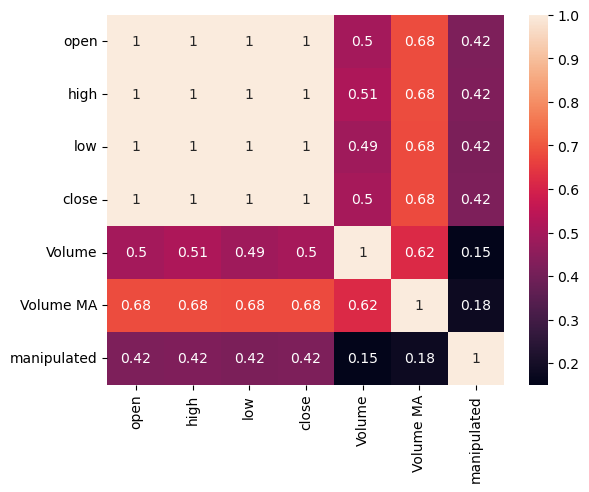

In [4]:
#CHCEK FOR CORRELATION 
corr_matrix = data.corr().abs()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [5]:
#1. RemoveHigh Collinearity
#select upper traingle of correlation matrix
#upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find index of columns with correlation greater than 0.95
#to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
# drop the columns
#data.drop(to_drop, axis=1, inplace=True)


In [6]:
#For Class Imbalance
#1. Oversampling
#print("Before OverSampling, counts of label '1': {}".format(sum(train_labels == 1)))
#print("Before OverSampling, counts of label '0': {} \n".format(sum(train_labels== 0)))

#from imblearn.over_sampling import SMOTE
#sm = SMOTE(random_state = 2)
#train_features, train_labels = sm.fit_resample(train_features, train_labels.ravel())
#print('After OverSampling, the shape of train_X: {}'.format(train_features.shape))
#print('After OverSampling, the shape of train_y: {} \n'.format(train_labels.shape))
  
#print("After OverSampling, counts of label '1': {}".format(sum(train_labels == 1)))
#print("After OverSampling, counts of label '0': {}".format(sum(train_labels == 0)))
#2. UnderSampling
#print("Before UnderSampling, counts of label '1': {}".format(sum(train_labels == 1)))
#print("Before UnderSampling, counts of label '0': {} \n".format(sum(train_labels== 0)))

#from imblearn.under_sampling import NearMiss
#nr = NearMiss()  
#print("Frauds in train before undersamling", np.sum(train_labels))
#train_features,train_labels = nr.fit_resample(train_features, train_labels.ravel())
#print("Frauds in train after undersampling", np.sum(train_labels))
#print('After Undersampling, the shape of train_X: {}'.format(train_features.shape))
#print('After Undersampling, the shape of train_y: {} \n'.format(train_labels.shape))
#print("After Undersampling, counts of label '1': {}".format(sum(train_labels == 1)))
#print("After Undersampling, counts of label '0': {}".format(sum(train_labels == 0)))   
    

In [7]:
#CHECK RATIO
normal = data[data.manipulated==0] 
fraud = data[data.manipulated==1]  

num_normal = normal.shape[0] 
num_fraud = fraud.shape[0]

print(f"Number of normal examples = {num_normal}")
print(f"Number of fraud examples = {num_fraud}\n")

ratio = num_normal/num_fraud

print(f"normal to fraud ratio in the whole data = {round(ratio,2)}")

# UNDERSAMPLING 
normal_fraud_ratio = 1                                      
normal_sample = normal.sample(normal_fraud_ratio*num_fraud) 



sample = pd.concat([fraud, normal_sample], axis=0)  


for i in range(100):
    sample = np.random.permutation(sample)                  



X, y = sample[:, :-1], sample[:, -1]

num_examples, num_features = X.shape   
print("number of examples = ", num_examples)
print("number of features = ", num_features)


Number of normal examples = 2142
Number of fraud examples = 28

normal to fraud ratio in the whole data = 76.5
number of examples =  56
number of features =  6


In [8]:
f= X
l= y
features = f
labels = l

In [9]:
#NORMALIZIG
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

<Axes: >

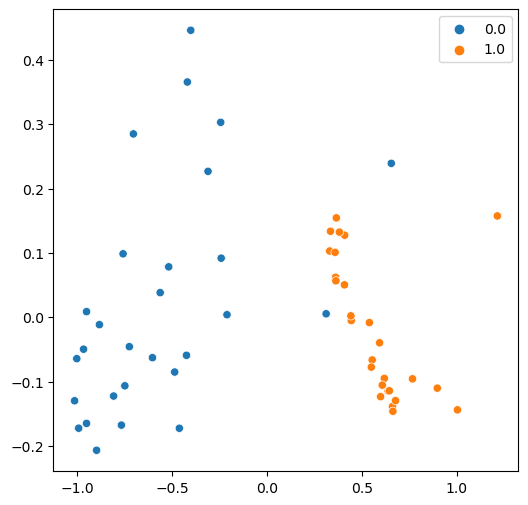

In [10]:
# REDUCTION FOR FEATURES 
from sklearn.decomposition import PCA

features = PCA(n_components=2).fit_transform(features)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

In [11]:
# For spliting data
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8)

In [12]:
# Encoding 
def predict(theta, data):
    outputs = [] # storing the measured value 
    for x in data:
        data_register = qk.QuantumRegister(2) 
        classical_register = qk.ClassicalRegister(1)
        qc = qk.QuantumCircuit(data_register, classical_register)
        qc.h(data_register[0])
        qc.h(data_register[1])
        qc.rz(2*np.pi*x[0],data_register[0])
        qc.rz(2*np.pi*x[1],data_register[1])
        qc.ry(theta[0], data_register[0])
        qc.ry(theta[1], data_register[1])
        qc.cx(data_register[0], data_register[1])
        qc.ry(theta[2], data_register[0])
        qc.ry(theta[3], data_register[1])
        qc.cx(data_register[0], data_register[1])
        qc.ry(theta[4], data_register[0])
        qc.ry(theta[5], data_register[1])
        qc.cx(data_register[0], data_register[1])
        qc.ry(theta[6], data_register[0])
        qc.ry(theta[7], data_register[1])
        qc.cx(data_register[0], data_register[1])
        qc.ry(theta[8], data_register[1])
        qc.measure(data_register[-1],classical_register[0]) # measuring the qubut in 1> ket state 
        shots=1000
        job = qk.execute(qc,
                backend=qk.Aer.get_backend('qasm_simulator'),
                shots=shots,
                seed_simulator=42
                )
        results = job.result()
        results = results.get_counts(qc)
        prediction = 0
        for key,value in results.items():
            if key == '1': 
                prediction += value      
        prediction/=shots # probability that this qubit is in the 1> state 
        outputs.append(prediction)
    return np.array(outputs)

In [13]:
n_params = 9 # no of parameters for 'ansatz'
theta = 2*np.pi*np.random.uniform(size=n_params)
theta

array([2.3772868 , 6.1128765 , 2.18416709, 0.64687198, 2.39968287,
       1.61459633, 3.15127358, 1.84848072, 0.79429986])

In [14]:
lr = 1 # learning rate
epochs = 2
loss = []
for i in range(epochs):
    y_pred = predict(theta, train_features)
    n_samples = train_features.shape[0] # no of samples in features 
    n_theta = theta.shape[0]            # no of parameters 
    shift = np.pi/2                     # for shifting parameter by a value of np.pi/2
    cross_entropy_deriv = (y_pred - train_labels)/(y_pred*(1-y_pred)) 
    grad = np.zeros((n_theta, n_samples))             # empty grad array for features length and theta length
 
    for i in range(n_theta):
        #parameter shift rule
        shift_vect = np.array([shift if j==i else 0 for j in range(n_theta)]) 
        shift_right = theta + shift_vect
        shift_left = theta - shift_vect
        
        expectation_right = predict(shift_right, train_features)
        expectation_left = predict(shift_left, train_features)

        grad[i] = expectation_right - expectation_left
    
    loss += -train_labels.dot(np.log(y_pred))
    gradients = 1.0/n_samples * grad.dot(cross_entropy_deriv) 
    # derivative of the loss with respect to the parameters 
    theta= theta - lr*gradients
    #accuracy = np.mean(np.round(y_pred).astype(int) == train_labels)
print (y_pred)

[0.202 0.668 0.77  0.459 0.54  0.477 0.255 0.521 0.281 0.299 0.772 0.699
 0.699 0.747 0.489 0.673 0.638 0.758 0.477 0.489 0.195 0.792 0.673 0.623
 0.526 0.632 0.44  0.78  0.765 0.73  0.39  0.4   0.703 0.258 0.748 0.662
 0.619 0.672 0.782 0.611 0.271 0.75  0.473 0.482]


In [15]:
y_train_pred = np.round(y_pred).astype(int)
y_train_pred

array([0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0])

In [16]:
lr = 1     # learning rate
epochs = 2 
loss_1=[]
for i in range(epochs):
    y_pred = predict(theta, test_features)
    n_samples = test_features.shape[0]   # no of samples in features 
    n_theta = theta.shape[0]    # no of parameters 
    shift = np.pi/2             # for shifting parameter by a value of np.pi/2
    cross_entropy_deriv = (y_pred - test_labels)/(y_pred*(1-y_pred))
    grad = np.zeros((n_theta, n_samples))   # empty grad array for features length and theta length
    
    for i in range(n_theta):
        #parameter shift rule
        shift_vect = np.array([shift if j==i else 0 for j in range(n_theta)])
        shift_right = theta + shift_vect
        shift_left = theta - shift_vect
        
        expectation_right = predict(shift_right, test_features)
        expectation_left = predict(shift_left, test_features)

        grad[i] = expectation_right - expectation_left
    loss_1 += -test_labels.dot(np.log(y_pred))
    gradients = 1.0/n_samples * grad.dot(cross_entropy_deriv) 
    # derivative of the loss with respect to the parameters 
    theta= theta - lr*gradients
    #accuracy = np.mean(np.round(y_pred).astype(int) == test_labels)
print (y_pred)

[0.748 0.262 0.757 0.363 0.255 0.875 0.638 0.749 0.666 0.073 0.636 0.176]


In [17]:
y_test_pred = np.round(y_pred).astype(int)
y_test_pred

array([1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0])

In [18]:
print(confusion_matrix(train_labels, y_train_pred), "= confusion matrix for train set \n")
print(confusion_matrix(test_labels, y_test_pred), "= confusion matrix for test set \n ")
print(round(roc_auc_score(test_labels, y_test_pred),2), "= roc_auc_score for test set \n")

[[13  8]
 [ 4 19]] = confusion matrix for train set 

[[5 2]
 [0 5]] = confusion matrix for test set 
 
0.86 = roc_auc_score for test set 



In [19]:
print(classification_report(train_labels, y_train_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.62      0.68        21
         1.0       0.70      0.83      0.76        23

    accuracy                           0.73        44
   macro avg       0.73      0.72      0.72        44
weighted avg       0.73      0.73      0.72        44



In [20]:
print(classification_report(test_labels, y_test_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83         7
         1.0       0.71      1.00      0.83         5

    accuracy                           0.83        12
   macro avg       0.86      0.86      0.83        12
weighted avg       0.88      0.83      0.83        12

